In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tqdm
from tqdm import tqdm
import joblib

In [2]:
# Device Setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Constants

MEAN = 0.2956
STD = 0.3069

data_dir = '/kaggle/input/fdata-adni-dataset/AugmentedAlzheimerDataset'

TEST_SIZE = 0.15
VAL_SIZE = 0.15

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[MEAN] * 3, std=[STD] * 3)
])

BATCH_SIZE = 32
NUM_CLASSES = 4
RANDOM_SEED = 43

SWIN_PATH = '/kaggle/input/swin-e-adni/pytorch/default/1/swin_model.pth'
VGG_PATH = '/kaggle/input/vgg-adni/pytorch/default/1/vgg_model.pth'

In [4]:
# Seeds
torch.manual_seed(RANDOM_SEED)
generator = torch.Generator().manual_seed(RANDOM_SEED) # Surity

In [5]:
# Datasets

master = datasets.ImageFolder(root=data_dir, transform=transform)

total_size = len(master)
test_size = int(TEST_SIZE * total_size)
val_size = int(VAL_SIZE * total_size)
train_size = total_size - test_size - val_size

train_set, val_set, test_set = random_split(master, [train_size, val_size, test_size], generator=generator)

In [6]:
print(f'Train: {len(train_set)}\nVal: {len(val_set)}\nTest: {len(test_set)}')

Train: 23790
Val: 5097
Test: 5097


In [7]:
# Models

swin = torch.load(SWIN_PATH)
vgg = torch.load(VGG_PATH)

swin.to(device)
vgg.to(device)

<ipython-input-7-45b262c387a8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  swin = torch.load(SWIN_PATH)
<ipython-input-7-45b262c387a8>:4: FutureWarning: You are using `

In [8]:
# Training the meta model

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

y_true = []
swin_pred_prob_list = []
vgg_pred_prob_list = []

with torch.no_grad():
    swin.eval()
    vgg.eval()
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        swin_outputs = swin(images)
        swin_probs = torch.softmax(swin_outputs, dim=1)
        swin_pred_prob_list.append(swin_probs.cpu().numpy())
        
        vgg_outputs = vgg(images)
        vgg_probs = torch.softmax(vgg_outputs, dim=1)
        vgg_pred_prob_list.append(vgg_probs.cpu().numpy())
        
        y_true.append(labels.cpu().numpy())

swin_pred_prob = np.concatenate(swin_pred_prob_list, axis=0)
vgg_pred_prob = np.concatenate(vgg_pred_prob_list, axis=0)
y_true = np.concatenate(y_true, axis=0)

combined_features = np.concatenate((swin_pred_prob, vgg_pred_prob), axis=1)

100%|██████████| 744/744 [04:08<00:00,  2.99it/s]


In [10]:
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED)
meta_model.fit(combined_features, y_true)

meta_train_preds = meta_model.predict(combined_features)
train_accuracy = accuracy_score(y_true, meta_train_preds)
print(f"Meta-model Training Accuracy: {train_accuracy:.4f}")

Meta-model Training Accuracy: 1.0000


In [11]:
joblib.dump(meta_model, 'mlr_meta_adni.pkl')

['mlr_meta_adni.pkl']

In [12]:
# Testing

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

swin_pred_prob_list_test = []
vgg_pred_prob_list_test = []
y_true_test = []

with torch.no_grad():
    swin.eval()
    vgg.eval()
    
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        
        swin_outputs = swin(images)
        swin_probs = torch.softmax(swin_outputs, dim=1)
        swin_pred_prob_list_test.append(swin_probs.cpu().numpy())
        
        vgg_outputs = vgg(images)
        vgg_probs = torch.softmax(vgg_outputs, dim=1)
        vgg_pred_prob_list_test.append(vgg_probs.cpu().numpy())
        
        y_true_test.append(labels.cpu().numpy())

swin_pred_prob_test = np.concatenate(swin_pred_prob_list_test, axis=0)
vgg_pred_prob_test = np.concatenate(vgg_pred_prob_list_test, axis=0)
y_true_test = np.concatenate(y_true_test, axis=0)

combined_features_test = np.concatenate((swin_pred_prob_test, vgg_pred_prob_test), axis=1)

100%|██████████| 160/160 [00:53<00:00,  3.00it/s]


In [13]:
meta_test_preds = meta_model.predict(combined_features_test)
meta_pred_prob_test = meta_model.predict_proba(combined_features_test)

Accuracy: 0.9971
Precision: 0.9971
Recall: 0.9971
F1 Score: 0.9971
Jaccard Index: 0.9941
MCC: 0.9961
AUC: 1.0000


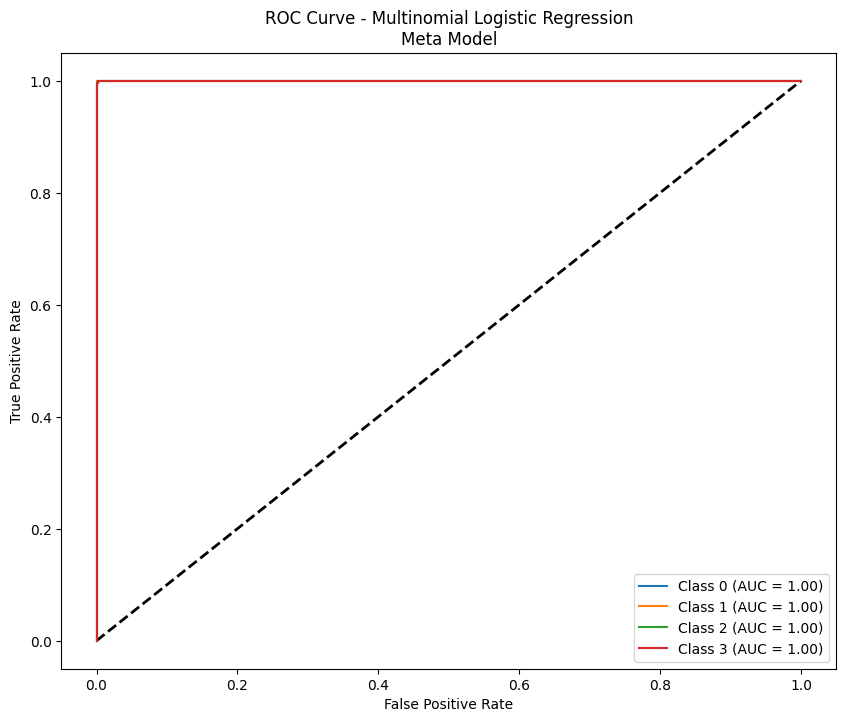

In [14]:
csv_path = 'mlr_meta_adni_metrics.csv'
model_name = f'Multinomial Logistic Regression\nMeta Model'
roc_path = 'mlr_meta_adni_ROC.pdf'

y_true_bin = label_binarize(y_true_test, classes=np.unique(y_true_test))
n_classes = y_true_bin.shape[1]

accuracy = accuracy_score(y_true_test, meta_test_preds)
precision = precision_score(y_true_test, meta_test_preds, average='weighted')
recall = recall_score(y_true_test, meta_test_preds, average='weighted')
f1 = f1_score(y_true_test, meta_test_preds, average='weighted')
jaccard = jaccard_score(y_true_test, meta_test_preds, average='weighted')
mcc = matthews_corrcoef(y_true_test, meta_test_preds)
auc_score = roc_auc_score(y_true_bin, meta_pred_prob_test, multi_class='ovr')
# auc_score = -1

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Jaccard Index: {jaccard:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"AUC: {auc_score:.4f}")

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Jaccard Index', 'MCC', 'AUC'],
    'Value': [accuracy, precision, recall, f1, jaccard, mcc, auc_score]
}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(csv_path, index=False)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=2)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], meta_pred_prob_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve' + ' - ' + model_name)
plt.legend(loc='lower right')
plt.savefig(roc_path, format='pdf', dpi=600)
plt.show()